In [7]:
import ndex2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import igraph
import networkx as nx
from random import randint
from cyjupyter import Cytoscape
%matplotlib inline


In [3]:
NETWORK_UUID = "cfd3528f-a7a4-11eb-9e72-0ac135e8bacf"
SERVER = "https://ndexbio.org"
test_network = ndex2.create_nice_cx_from_server(SERVER, uuid=NETWORK_UUID)
test_network.print_summary()
#test_networkx = test_network.to_networkx()
#test_pos = make_networkx_pos_from_cx_coordinates(test_network)
#nx.draw(test_networkx, test_pos)
#print(test_network.get_opaque_aspect(ndex2.constants.CARTESIAN_LAYOUT_ASPECT))

Name: Sonic Hedgehog
Nodes: 18
Edges: 45
Node Attributes: 36
Edge Attributes: 450



In [10]:
test_cx = test_network.to_cx()
Cytoscape(data=test_cx, format='cx')

Generating CX


Cytoscape(data=[{'numberVerification': [{'longNumber': 281474976710655}]}, {'metaData': [{'name': 'nodes', 'el…

In [19]:
def igraph_from_nice_cx(nice_cx):
    g = igraph.Graph(len(nice_cx.get_nodes()))
    # network attributes
    for name in nice_cx.get_network_attribute_names():
        value = nice_cx.get_network_attribute(name)["v"]
        #print(value)
        g[name]=value      
    # attribute declarations
    # nodes and attributes and coordinates
    # make a node_id list
    node_id_list = []
    n_id = 0
    for node_id, node in nice_cx.get_nodes():
        g.vs[n_id]["cx_id"] = node_id
        atts = nice_cx.get_node_attributes(node_id)
        for att in atts:
            att_name = att["n"]
            att_value = att["v"]
            g.vs[n_id][att_name] = att_value
        n_id += 1
        
    # edges and attributes
    for edge_id, edge in nice_cx.get_edges():
        cx_source_id = edge["s"]
        cx_target_id = edge["t"]
        g_source = g.vs.find(cx_id=cx_source_id)
        g_target = g.vs.find(cx_id=cx_target_id)
        g.add_edges([(g_source, g_target)])
        e_id = g.get_eid(g_source, g_target)
        g.es[e_id]["cx_id"] = edge_id
        atts = nice_cx.get_edge_attributes(node_id)
        for att in atts:
            att_name = att["n"]
            att_value = att["v"]
            g.es[e_id][att_name] = att_value

    # cartesian coordinates
    g["cartesian_layout"] = nice_cx.get_opaque_aspect(ndex2.constants.CARTESIAN_LAYOUT_ASPECT)
    #visual styles
    # bypasses
    # rules
    return g
   

In [20]:
g = igraph_from_nice_cx(test_network)
print(g.es[1])

igraph.Edge(<igraph.Graph object at 0x12cafe8b0>, 1, {'cx_id': 1, 'citation': ['pubmed:16571352'], 'mechanism': 'transcriptional regulation', 'residue': '', 'sequence': '', 'cell_data': ['BTO:0002572'], 'tissue_data': [''], 'notes': '', 'annotator': 'lperfetto', 'sentence': 'Primary mouse embryonic fibroblasts responded to Shh stimulation with the induction of Hh target genes Gli1, Ptc1, and Hip1.These observations support the previously advanced notion of a functional redundancy or cooperativity between Gli2 and Gli1 in activation of target genes [18] and [43] and indicate a functional cooperation between Gli3 and Gli1.', 'direct': 'false'})


In [25]:
#l = [(0,0)]*10
#print(l)

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


In [29]:
def igraph_layout_from_cx_cartesian_layout(g):
    cx_layout = g["cartesian_layout"]
    igraph_layout = [(0,0)] * len(g.vs)
    for node in cx_layout:
        igraph_node_id = node["node"]
        igraph_layout[igraph_node_id] = (node["x"],node["y"])
    return igraph.Layout(igraph_layout)

l = igraph_layout_from_cx_cartesian_layout(g)
l
                                         
        
        
        

<Layout with 18 vertices and 2 dimensions>

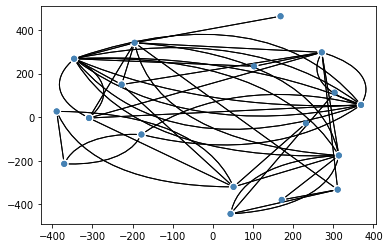

In [31]:
#layout = g.layout("kk")
layout = igraph_layout_from_cx_cartesian_layout(g)
fig, ax = plt.subplots()
#G = g.to_networkx()
#nx.draw(G, node_size=50)
#plt.show()
igraph.plot(g, layout=layout, target=ax)

In [4]:
def make_networkx_pos_from_cx_coordinates(cx_network):
    cart_coords = cx_network.get_opaque_aspect(ndex2.constants.CARTESIAN_LAYOUT_ASPECT)
    pos = {}
    for node in cart_coords:
        pos[node["node"]] = (node["x"],node["y"])     
    return pos

### make a fresh gameboard
initialized to zeros
a square numpy array with area scaled to the sqrt of the node count

In [129]:
def make_gameboard (cx_network, sparsity=15):
    node_count = len(list(cx_network.get_nodes()))
    dimension = round(math.sqrt(node_count * sparsity))
    return np.zeros((dimension, dimension), dtype=np.int16)

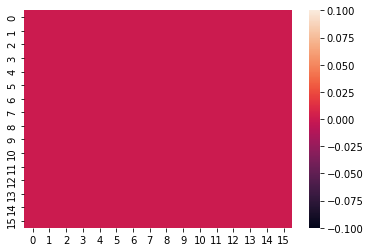

In [130]:
gb = make_gameboard(test_network)
sns.heatmap(gb)
plt.show()

make the cartesian coordinates aspect, set random coordinates
but no two nodes can have the same coordinates
check this by placing ones on the board



4   14
4   15
2   13
13   5
0   2
4   7
0   11
12   4
12   3
5   10
0   6
2   14
4   5
8   7
14   10
3   6
3   2
5   6


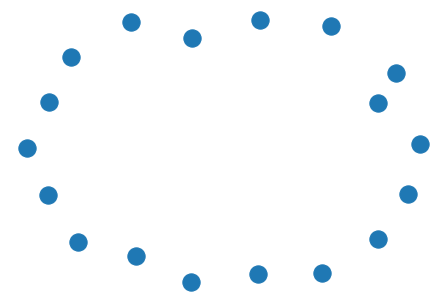

In [134]:
def make_coordinates (cx_network, gameboard):
    dimension = gameboard.shape[0]
    coords = {}
    nodes = cx_network.get_nodes()
    for node_id, node in nodes:
        #print(node)
        placed = False
        while not placed:
            x = randint(0,dimension-1)
            y = randint(0,dimension-1)
            if gameboard[x, y] == 0:
                gameboard[x, y] = 1
                placed = True
        coords[node_id]= {
            'x' : x,
            'y' : y,
            'adj' : set()
       }
    for edge_id, edge in cx_network.get_edges():
        #print(edge)
        coords[edge["s"]]['adj'].add(edge['t'])
        coords[edge["t"]]['adj'].add(edge['s'])
    return coords

def make_networkx_from_coordinates(coords):
    G2 = nx.Graph()
    for node_id, node in coords.items():
        G2.add_node(node_id, pos=(node['x'], node['y']))
    return G2
    
    
c = make_coordinates(test_network, gb)
for node_id, node in c.items():
    print(node['x'], " ", node['y'])
    
netx = make_networkx_from_coordinates(c)
nx.draw(netx)

{0: (-194.81752104685228, 341.1556784714861),
 1: (168.70355633570472, 462.60231061653735),
 2: (-370.1779718732629, -213.92376535888778),
 3: (-177.80028188219646, -79.27479882356458),
 4: (-388.90996751779716, 26.452967981357475),
 5: (-308.353466608449, -3.8623955019929497),
 6: (-345.3897613077736, 267.82477825654627),
 7: (102.71905863666443, 233.1379138732143),
 8: (369.09332727116106, 56.149769149403596),
 9: (-227.15106764785702, 149.41837683475902),
 10: (51.60602560382486, -319.4337035650593),
 11: (271.46000223921544, 297.17064693852035),
 12: (311.05314747989297, -331.92598328851466),
 13: (171.6174281612348, -379.0878500685345),
 14: (44.10487676273895, -443.2994647322332),
 15: (313.89364428267976, -175.35428590274148),
 16: (303.30645828698954, 112.57542544394711),
 17: (231.91044163333862, -27.844730907492014)}

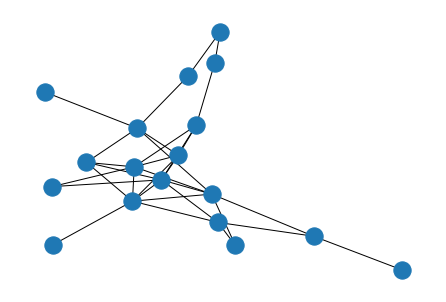

In [132]:
#test_network.print_summary()
gb = make_gameboard(test_network)
c = make_coordinates(test_network, gb)
networkx_test = test_network.to_networkx()
#print(c)
#node_pos=nx.get_node_attributes(networkx_test,'pos')
#print(node_pos)
nx.draw(networkx_test)
networkx_test.pos

{900: (0, 0), 901: (1, 0), 902: (0, 1), 903: (1, 1), 904: (0, -1)}


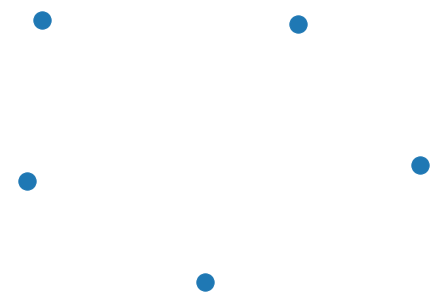

In [110]:
G2 = nx.Graph()
G2.add_node(900,pos=(0,0))
G2.add_node(901,pos=(1,0))
G2.add_node(902,pos=(0,1))
G2.add_node(903,pos=(1,1))
G2.add_node(904,pos=(0,-1))
node_pos=nx.get_node_attributes(G2,'pos')
print(node_pos)
nx.draw(G2)

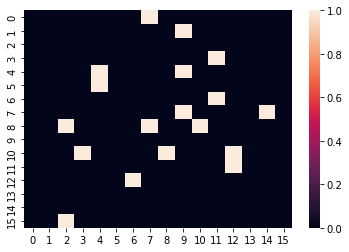

In [114]:
sns.heatmap(gb)
plt.show()

In [41]:
def energy_field(radius, attract=True):
    dimension = (2*radius)+1
    ef = np.zeros((dimension, dimension), dtype=np.int16)
    for x in range(0, dimension):
        dx = abs(radius - x)
        for y in range(0, dimension):
            dy = abs(radius - y)
            distance = int(math.sqrt(dx**2 + dy**2))
            if attract:
                ef[x,y] = distance
            else:
                energy = abs(distance - radius)
                ef[x,y] = energy
    return ef

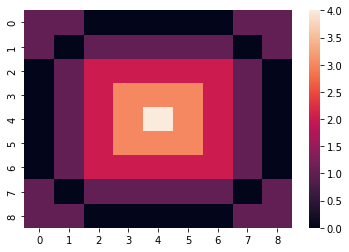

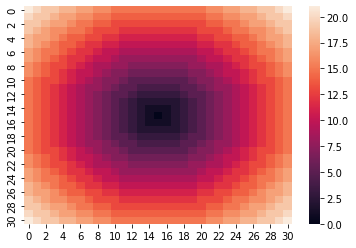

In [98]:
rf=energy_field(4, attract=False)
sns.heatmap(rf)
plt.show()
af=energy_field(15)
sns.heatmap(af)
plt.show()

In [126]:
def add_field(r_field, g_field, x, y, remove=False, show_coords=False):
    if show_coords: print("coords", x,y)
    gx_max = g_field.shape[0] - 1
    gy_max = g_field.shape[1] - 1
    rx_max = r_field.shape[0] - 1
    ry_max = r_field.shape[1] - 1
    #
    #   0.0 1.0 2.0
    #   0.1 1.1 2.1
    #   0.2 1.2 2.2
    #
    x_offset = int(r_field.shape[0]/2)
    y_offset = int(r_field.shape[1]/2)
    #print("gb shape", g_field.shape)
    #print("rf offset", x_offset, y_offset)
    gtx = x - x_offset
    gty = y - y_offset
    gbx = x + x_offset
    gby = y + y_offset
    #print("gb target", gtx,gty,gbx,gby)
    rtx = 0
    rty = 0
    rbx = rx_max
    rby = ry_max
    #print("rf source", rtx,rty,rbx,rby)
    # trim if r_field goes off board negative
    if gtx < 0:
        #print("negative x")
        rtx = -gtx
        gtx = 0        
    if gty < 0:
        #print("negative y")
        rty = -gty
        gty = 0
    # trim if r_field goes off board positive
    if gbx > gx_max:
        dx = gbx - gx_max
        #print("positive x", dx)
        gbx = gx_max
        rbx = rx_max - dx
    if gby > gy_max:
        dy = gby - gy_max
        #print("positive y", dy)
        gby = gy_max
        rby = ry_max - dy
    #print("adj gb target", gtx,gty,gbx,gby) 
    #print("adj rf source", rtx,rty,rbx,rby)
    #gameboard[gtx, gty] = 1
    #gameboard[gbx, gby] = 1
    # add the r_field to the g_field
    #print(g_field[gtx:gbx+1, gty:gby+1])
    #print(r_field[rtx:rbx+1, rty:rby+1])
    if remove:
        g_field[gtx:gbx+1, gty:gby+1] -= r_field[rtx:rbx+1, rty:rby+1]
    else:
        g_field[gtx:gbx+1, gty:gby+1] += r_field[rtx:rbx+1, rty:rby+1]

# wrapper for readability
def subtract_field(r_field, g_field, x, y, show_coords=False):
    add_field(r_field, g_field, x, y, remove=True, show_coords=show_coords)
        
def layout_node_step(repulsion_board, s_field, r_field, a_field, node, coords):
    # make a scratchpad board where we add all the attraction fields
    # and the use it to select the destination and update the repulsion board
    s_field = np.copy(repulsion_board)
    for adj_node_id in node['adj']:
        # add an attraction field for each, to the scratchpad field
        adj_node = coords[adj_node_id]
        add_field(a_field, s_field, adj_node["x"], adj_node["y"])
    # select the destination
    # idea #1: choose a location with the minimum value
    # argmin returns the index of the first location containing the minimum value in a flattened 
    # version of the array
    # unravel_index turns the index back into the coordinates
    destination = np.unravel_index(np.argmin(s_field, axis=None), s_field.shape)
    #print(node)
    #print("destination: ", destination)

    # move the node on the repulsion board
    # subtract it at it's current location
    subtract_field(r_field, repulsion_board, node['x'], node['y'])
    # add it at the destination
    add_field(r_field, repulsion_board, destination[0], destination[1])
    # update its coordinates
    node["x"] = destination[0]
    node["y"] = destination[1]

# subtract the r_field from the repulsion board in the old location
# update the coordinates
# add the r_field to the repulsion board at the destination
    
def layout_round(repulsion_board, s_field, r_field, a_field, coords):
    for node_id, node in coords.items():
        layout_node_step(repulsion_board, s_field, r_field, a_field, node, coords)
    network_x_temp = make_networkx_from_coordinates(coords)
    nx.draw(network_x_temp)
    plt.show()
    print("----")
    sns.heatmap(af)
    plt.show()
        
    
def layout_network(cx_network, rounds=1, sparsity=15, repulsion_radius=4):
    # initialize the gameboard
    gameboard = make_gameboard(cx_network, sparsity=sparsity)
    coords = make_coordinates(cx_network, gameboard)
    r_field = energy_field(repulsion_radius, attract=False)
    a_field = energy_field(gameboard.shape[0])
    for node_id, node in coords.items():  
        add_field(r_field, gameboard, node["x"], node["y"])
    network_x_temp = make_networkx_from_coordinates(coords)
    nx.draw(network_x_temp)
    plt.show()
    print("----")
    sns.heatmap(gameboard)
    plt.show()
    # perform the rounds of layout
    for n in range(0, rounds):
        print("round ", round)
        layout_round(gameboard, np.copy(gameboard), r_field, a_field, coords)
    for node_id, node in coords.items():
        print(node['x'], node['y'])
        
    

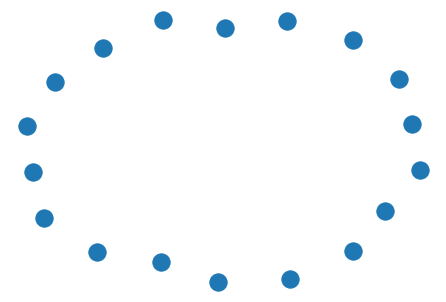

----


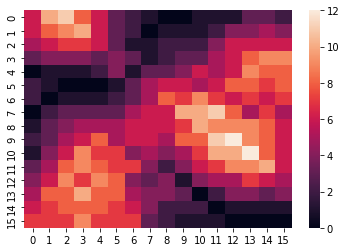

round  <built-in function round>


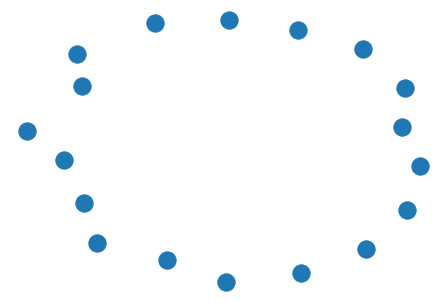

----


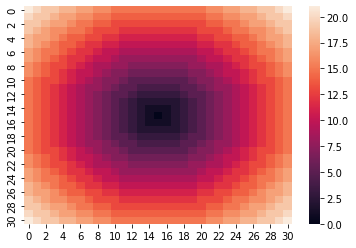

5 4
4 0
3 8
0 11
6 11
4 11
8 7
7 8
0 11
9 8
6 11
6 7
5 4
8 1
12 9
9 6
13 6
5 15


In [127]:
layout_network(test_network)